In [1]:
# main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Extra packages
from datetime import date
import holidays
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from statsmodels.graphics.tsaplots import plot_acf

## Feature Generation

The feature generation step is responsible to created new features that somehow offer additional information to the machine learning models towards the enhancement of their output predictions. In the scope of this work, the output is the energy consumption of each building, therefore, each new feature most be generated in attempt to describe its behavior and particular characteristics.

In this study, the new features, may be grouped according to what they are based on, therefore, there are **three main categories**:

- Time
- Calendar
- Energy consumption. 

The first includes every new feature that was time dependent, the second group of features was based on the national and academic calendar, and lastly, the third group generates features that were based on each building own consumption.

<img src="https://imgur.com/g1VJ0Dd.png" width="800" height="500" align="center"/>
<center> Fig.1 - Data Imputation Study - Diagram <center>

We are going to call all the data sets that resulted from the **Data Imputation Strategy** of notebook **01-01-Data_Treatment**.

In [2]:
dt_01 = pd.read_csv('Preprocessed_Data/_01_dt_01.csv', index_col=[0], parse_dates=[0], header=0)
dt_02 = pd.read_csv('Preprocessed_Data/_01_dt_02.csv', index_col=[0], parse_dates=[0], header=0)
dt_03 = pd.read_csv('Preprocessed_Data/_01_dt_03.csv', index_col=[0], parse_dates=[0], header=0)

---

### 1.1 Time

This group of new features, was supported by the patterns encounter in each of the temporal partitions performed in the consumption analysis, in the previous notebook **02-00-EDA-Energy_Consumption_Analysis**. In attempt to offer to the forecasting models the possibility to distinguish those patterns three features were generated with integers values that differ depending on the temporal partition,

Example: for monthly partition, integers from 1 to 12 were set in the new feature. The three new features were named after each temporal partition, specifically **t_month**, **t_dayofweek**, and **t_hour**.

They were already created in the first notebook **01-00-Data_Treatment** to ease the analyses.

In [3]:
dt_01.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23763 entries, 2014-01-01 01:00:00 to 2018-12-31 23:00:00
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   civil             23763 non-null  float64
 1   south_tower       23763 non-null  float64
 2   wt_temp           23763 non-null  float64
 3   wt_tmpap          23763 non-null  float64
 4   wt_hr             23763 non-null  float64
 5   wt_max_windgust   23763 non-null  float64
 6   wt_mean_windspd   23763 non-null  float64
 7   wt_mean_pres      23763 non-null  float64
 8   wt_mean_solarrad  23763 non-null  float64
 9   wt_rain_day       23763 non-null  float64
 10  t_hour            23763 non-null  int64  
 11  t_month           23763 non-null  int64  
 12  t_dayofweek       23763 non-null  int64  
 13  t_year            23763 non-null  int64  
 14  miss_civil        23763 non-null  int64  
 15  miss_south_tower  23763 non-null  int64  
 16  miss_

---

### 1.2. Calendar

In the absence of each building real occupancy data, this category was implemented. Basically attempts to replicate the real occupancy per day, with two different features. For that, each of the features use integer values, **levels**, that quantify the expected daily occupancy rate, being the lowest level the one that has the smallest occupancy rate.

#### 1.2.1 Workday Feature

The first feature, named as **s_workday**, specifies the type of day in three distinguished levels, defined
as:
- **Level 0** - represents weekends and the two weeks yearly summer break of all campus facilities;
- **Level 1** - identifies the holidays that occur during the week. This level, although representing
non-working days, in the case of an institutional buildings, their rate of occupancy is, usually,
in-between the other two levels;
- **Level 2** - as the last level in s_workday feature, represents the normal working days, where
the occupancy rate is expected to be the highest.

In [4]:
def create_workday(dt):
    '''
    Creates a new column that quantifies the type of day in three different levels. 
    It uses holiday package to know which day is an national holiday in Portugal.
    
    Input: DataFrame
    Output: DataFrame
    '''
    
    # Instantiate Portugal object
    port_holidays = holidays.PortugalExt()
    
    # Adapt object
    # Remove 26th holiday - once all the buildings behave like it's a normal working day
    for year in dt['t_year'].unique():
        port_holidays.pop(str(year)+'-12-26')
    
    # Add more holidays to the package
    port_holidays.append({'2014-06-19':'Corpo de Deus',
                          '2014-10-05':'Implantação da República', 
                          '2014-10-01':'Dia de Todos os Santos', 
                          '2014-12-01':'Restauração da Independência'})

    # Create new column
    dt['s_workday'] = (dt['civil']*0)+2
    
    # Generation of 1 for holidays and 0 for workdays
    x = range(0, len(dt))
    for hour in x:    
        workday = dt['s_workday'][hour]
        weekday = dt['t_dayofweek'][hour]
        # Indexing the days - to add more vacations
        idx = dt.index[hour]   
        d = idx.day
        m = idx.month
        y = idx.year

        # Append holdays
        if date(y,m,d) in port_holidays:
            dt['s_workday'][hour] = 1
            
        # Weekend days
        elif weekday == 5 or weekday == 6:
            dt['s_workday'][hour] = 0
    
    # Adapt object - Summer Break of Instituto Superior Técnico, Universidade de Lisboa
    # 2014 - Summer break
    august_14 = pd.date_range(start='2014-08-04', end='2014-08-15')
    dt['s_workday'][pd.DatetimeIndex(dt.index.date).isin(august_14)] = 0

    # 2017 - Summer break
    august_17 = pd.date_range(start='2017-07-31', end='2017-08-11')
    dt['s_workday'][pd.DatetimeIndex(dt.index.date).isin(august_17)] = 0

    # 2018 - Summer break
    august_18 = pd.date_range(start='2018-08-06', end='2018-08-17')
    dt['s_workday'][pd.DatetimeIndex(dt.index.date).isin(august_18)] = 0
    
    return dt

In [5]:
# Create s_workday feature
dt_01 = create_workday(dt_01)
dt_02 = create_workday(dt_02)
dt_03 = create_workday(dt_03)

##### Extra Section: Workday feature vs. Clusters

As promised we are going to check the quality of the s_workday and time features assuming that the clusters previously identified can propertly identify the day type.

In [6]:
def column_aggregation_to_dataset(cl_building_pivot, original_dt, building_name):
    
    # Drop unnecessary data
    cl = cl_building_pivot.reset_index(level='cluster')
    cl = cl.drop([building_name], axis = 1)
    
    # Set again to hourly data - respecting clusters
    cl.index = pd.to_datetime(cl.index)
    cl = cl.resample('H').pad()
    
    # Rename column
    column_name = building_name+'_cl'
       
    cl.columns = [column_name]
    
    # Add column to original dataset
    new_dt = pd.merge(original_dt,cl, how='inner', left_index=True, right_index=True)
    
    return new_dt, cl

def workday_season_vs_cluster(dt, building):
    
    # To know the quantity of clusters
    k = len(dt[building+'_cl'].unique())
    
    # List of percentages
    perc = []
    
    # For loop need
    for i in range(k): 
        # All data from a cluster
        cluster = dt[dt[building+'_cl'] == i]
        total = len(cluster)

        
        # Workday
        wd = len(cluster[cluster['s_workday']==2])
        h = len(cluster[cluster['s_workday']==1])
        wk = len(cluster[cluster['s_workday']==0])
        
        # Season Heating vs. Cooling
        heating_season = [1, 2, 3, 4, 11, 12]
        heating = len(cluster.loc[cluster['t_month'].isin(heating_season)])
        cooling_season = [5, 6, 7, 8, 9, 10]
        cooling = len(cluster.loc[cluster['t_month'].isin(cooling_season)])
               
        # Percentage
        perc_wd = round((wd/total)*100, 1)
        perc_h = round((h/total)*100, 1)
        perc_wk = round((wk/total)*100, 1)
        
        perc_heat = round((heating/total)*100, 1)
        perc_cool = round((cooling/total)*100, 1)
        
        perc.append(['k='+str(i), perc_wd, perc_h, perc_wk, perc_heat, perc_cool])
        
    perc_dt = pd.DataFrame(data=perc,columns=['Cluster','workday(%)','holiday(%)','weekend and summer break(%)', 'Heating Season(%)', 'Cooling Season(%)']).set_index('Cluster')
        
    return perc_dt

In [7]:
# Import Data
k_civil_pivot = pd.read_csv('Preprocessed_Data/_02_pivot_civil_clustered.csv', index_col=[0,1], header=[0,1])
k_stw_pivot = pd.read_csv('Preprocessed_Data/_02_pivot_stw_clustered.csv', index_col=[0, 1], header=[0, 1])

**Civil Building**

<a id='civil_building'></a>

<img src="https://imgur.com/PSVhwVF.png" width="800" height="500" align="center"/>
<center> <b>Fig.2</b> - Data Imputation Study - Diagram <center>

In [8]:
dt_cl, civil_cl = column_aggregation_to_dataset(k_civil_pivot, dt_01, 'civil')
workday_season_vs_cluster(dt_cl, 'civil')

,workday(%),holiday(%),weekend and summer break(%),Heating Season(%),Cooling Season(%)
Cluster,,,,,
k=0,95.6,2.0,2.3,43.3,56.7
k=1,3.8,11.1,85.1,52.6,47.4
k=2,99.4,0.0,0.6,57.6,42.4


**South tower**

<a id='south_tower'></a>

<img src="https://imgur.com/m84M0bX.png" width="800" height="500" align="center"/>
<center> <b>Fig.3</b> - South tower building daily consumption patterns defined by k-means algorithm (k=3) <center>

In [9]:
dt_cl, stw_cl = column_aggregation_to_dataset(k_stw_pivot, dt_01, 'south_tower')
workday_season_vs_cluster(dt_cl, 'south_tower')

,workday(%),holiday(%),weekend and summer break(%),Heating Season(%),Cooling Season(%)
Cluster,,,,,
k=0,4.1,10.5,85.3,62.0,38.0
k=1,98.1,0.0,1.9,2.2,97.8
k=2,97.6,1.6,0.8,88.6,11.4
k=3,26.7,9.8,63.5,26.0,74.0


It can be seen that the **s_workday** and **time** features are able to define the type of day:

- The workday percentage of days in clusters k=0 and k=2 for **Civil building** and also in k=1 and k=2 for **South tower** is almost 100%;
- The holiday percentage of days is almost pratically clustered in one cluster (k=2) for **Civil building** and for two clusters (k=0 and k=3) for **South tower**.

<div class="alert alert-block alert-success">
    <b>NOTE</b>: It is also possible to notice that <b>South Tower</b> is greatly influenced by heating and cooling season as referred earlier in the monthly analysis (<b>02-00-EDA-Energy_Consumption_Analysis</b>), in opposition <b>Civil building</b> that has around 50% of days in cooling and heating season is not influenced at all by different seasons.
</div>

#### 1.2.2 Exam Seasons Feature

The second feature, denoted as **s_epochs**, attempts to give the model information about the different types of occupancy occurring when there is exams, classes, and break periods during the [academic calendar](https://conselhopedagogico.tecnico.ulisboa.pt/documentos/calendarios/). For that, also three levels were specified:

- **Level 0** - corresponds again, to the lowest rate of occupancy, the break period between semesters;
- **Level 1** - identifies the exams period, with no classes;
- **Level 2** - refers to the classes period of each of the academic semesters.

In [10]:
def different_epochs(dt):
    '''
    Creates a new column that quantifies the type of day in three different levels, 
    based on Instituto Superior Técnico Academic Calendar
    
    Input: DataFrame
    Output: DataFrame
    '''    
    # Create new column
    dt['s_epochs'] = dt['civil']*0
    
    #### 2014
    ### CLASS PERIOD
    ## 2nd Semester
    class_14_2 = pd.date_range(start='2014-02-17', end='2014-05-30')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(class_14_2)] = 2

    # Breaks in 2nd semester
    # Carnival
    carnival_14 = pd.date_range(start='2014-03-03', end='2014-03-04')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(carnival_14)] = 0 
    # Easter Break
    easter_14 = pd.date_range(start='2014-04-13', end='2014-04-20')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(easter_14)] = 0
    
    ## 1st Semester
    class_14 = pd.date_range(start='2014-09-15', end='2014-12-19')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(class_14)] = 2

        
    ## EXAMS PERIOD
    # represent all the period, with first and second wave of exams
    ## 1st semester
    exam_14 = pd.date_range(start='2014-01-03', end='2014-02-01')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(exam_14)] = 1
    
    ## 2nd semester
    exam_14_2 = pd.date_range(start='2014-06-07', end='2014-07-04')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(exam_14_2)] = 1
    
    
    
    #### 2017
    ### Class Period
    ## 2nd Semester
    class_17_2 = pd.date_range(start='2017-02-20', end='2017-06-02')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(class_17_2)] = 2
    
    # Breaks in 2nd semester
    # Carnival
    carnival_17 = pd.date_range(start='2017-02-27', end='2017-02-28')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(carnival_17)] = 0 
    # Easter Break
    easter_17 = pd.date_range(start='2017-04-10', end='2017-04-14')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(easter_17)] = 0
    
    
    ## 1st Semester
    class_17_2 = pd.date_range(start='2017-09-18', end='2017-12-15')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(class_17_2)] = 2


    ## EXAMS PERIOD
    # represent all the period, with first and second wave of exams
    ## 1st semester
    exam_17 = pd.date_range(start='2017-01-07', end='2017-02-04')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(exam_17)] = 1
    
    ## 2nd semester
    exam_17_2 = pd.date_range(start='2017-06-12', end='2017-07-08')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(exam_17_2)] = 1


    #### 2018
    ### CLASS PERIOD
    ## 2nd Semester
    class_18_2 = pd.date_range(start='2018-02-19', end='2018-06-01')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(class_18_2)] = 2
    
    # Breaks in 2nd semester
    # Easter Break
    easter_18 = pd.date_range(start='2018-04-26', end='2018-04-30')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(easter_18)] = 0
    
    
    ## 1st Semester
    class_18 = pd.date_range(start='2018-09-17', end='2018-12-21')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(class_18)] = 2

    ## EXAMS PERIOD
    # represent all the period, with first and second wave of exams
    ## 1st semester
    exam_18 = pd.date_range(start='2018-01-06', end='2018-02-03')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(exam_18)] = 1
    
    ## 2nd semester
    exam_18_2 = pd.date_range(start='2018-06-09', end='2018-07-07')
    dt['s_epochs'][pd.DatetimeIndex(dt.index.date).isin(exam_18_2)] = 1
    
    return dt

In [11]:
# Create s_epochs feature
dt_01 = different_epochs(dt_01)
dt_02 = different_epochs(dt_02)
dt_03 = different_epochs(dt_03)

---

### 1.3. Energy Consumption

This category was used to create a sort of **“guidelines”** using each building consumption, to enhance
the performance of the forecasting models. These “guidelines” can be distinguished into two different
groups, according to the technique used to generate them.

#### 1.3.1 Average Cluster Consumption

This first group uses the mean daily pattern consumption of each cluster identified in 2017 year (previous notebook **02-00-EDA-Energy_Consumption_Analysis**) to create a new feature. 

Basically, this feature replicates each cluster mean pattern along all the data frame, as it is illustrate in **Fig. 4**.

There are as many new features per building as clusters identified:
- [3](#civil_building) clusters/features for Civil Building
- [4](#south_tower) clusters/features for South Tower

To identify each feature the correspondent cluster’s number `k` was used as feature name suffix, e.g. for cluster `k = 0` of Civil building the feature name is `cl_civil_0`

<img src="https://imgur.com/lM23B2W.png" width="550" height="400" align="center"/>
<center> <b>Fig.4</b> - Civil Building cluster average feature from k=0 <center>

In [12]:
def create_mean_cluster_feat(dt, building_name):
    
    # dt_02 will be used for the clusters, since its the one that the consumption of each building was not dropped nor imputed
    # Year = 2017 - since it is the closest year to the prediction year
    building = pd.read_csv('Preprocessed_Data/_01_dt_02.csv', index_col=[0], parse_dates=[0], header=0)['2017']
    building = building[[building_name]+['t_hour']]
    building.index = building.index.date
    
    # Pivot column 't_hour' & drop incompleted days
    building_pivot = building.pivot(columns='t_hour').dropna()
    
    # Create a copy of a dataframe
    X_building = building_pivot.values.copy()
    
    # Scale for K-Means
    scaler = MinMaxScaler()
    X_building = scaler.fit_transform(X_building)
    
    # Predefined Silhouette Scores by building
    if building_name == 'civil':
        n_clusters = 3
        
    # Representing South tower
    else:
        n_clusters = 4
    
    kmeans = KMeans(n_clusters=n_clusters)
    
    cluster_found = kmeans.fit_predict(X_building)
    
    # Convert each day to series
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    
    # Append cluster data
    clustered_building_pivot = building_pivot.set_index(cluster_found_sr, append=True)

    # Create a column for each n_clusters of the mean hourly data
    for i in range(n_clusters):
        mapping = dict(clustered_building_pivot.xs(i, level=1).mean().reset_index(level=0)[0])
        dt['cl_'+building_name+'_'+str(i)] = dt.index.hour.map(mapping)
        
    return dt


def cluster_pattern(dt):
    buildings = ['civil', 'south_tower']
    for name in buildings:
        dt = create_mean_cluster_feat(dt, name)
    return dt         
    

In [13]:
dt_01 = cluster_pattern(dt_01)
dt_02 = cluster_pattern(dt_02) 
dt_03 = cluster_pattern(dt_03)

#### 1.3.2 Lagged Consumption

The second anf last group of generated features was defined taking into account the common use of lagged features in time series analyses. 

This new group of features was based in the **autocorrelation of each building energy consumption**. The autocorrelation was obtained using **Pearson's correlation** between a chosen number of previous hours and the actual hour, **Fig 5** and **6**.

In [25]:
def auto_correlation_plot(dt, building, lags):
    fig, ax = plt.subplots(figsize=(20,10))
    plot_acf(dt[building],ax=ax,lags=lags);
    ax.set_title('Autocorrelation: Hourly Energy Consumption '+ building.capitalize(), fontsize=22)
    ax.set_xlabel('Hourly Consumption Lags', fontsize=16)
    ax.set_ylabel('Autocorrelation', fontsize=16)
    plt.xlim(0-2, lags+2)

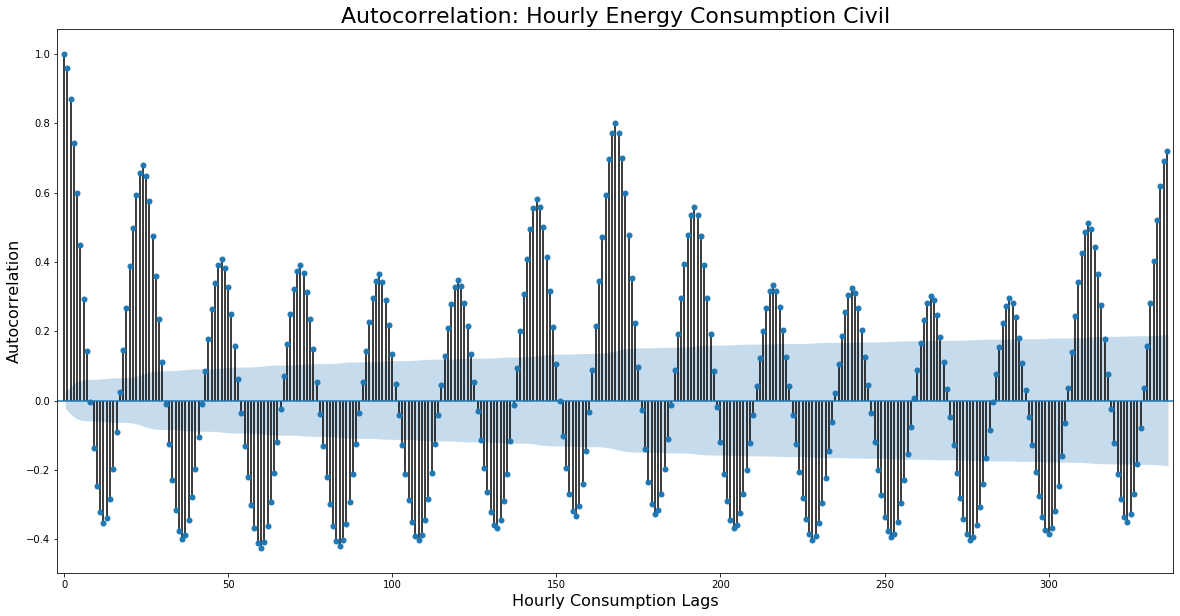

In [26]:
auto_correlation_plot(dt_02['2018'], 'civil', 24*14)

<center> <b>Fig.5</b> - Autocorrelation of Civil building hourly energy consumption <center>

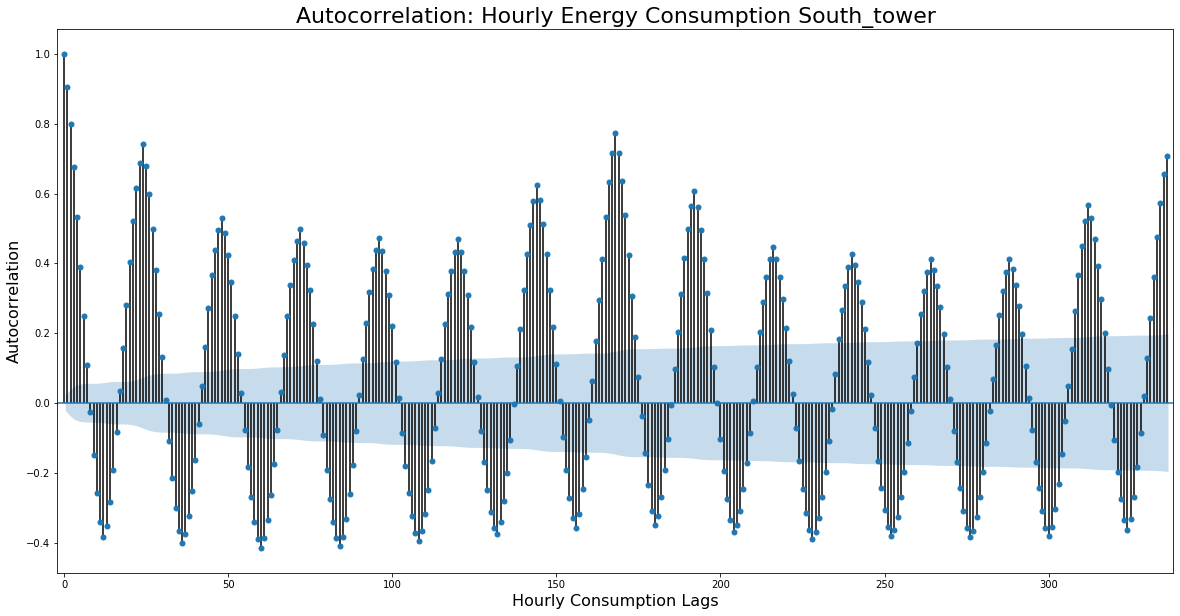

In [16]:
auto_correlation_plot(dt_02['2018'], 'south_tower', 24*14)

<center> <b>Fig.6</b> - Autocorrelation of South tower building hourly energy consumption <center>

From **Fig 5** and **6**, it is noticeable that the three most autocorrelated periods, take place first at the **previous hour**, then a **week before**, and lastly at the **previous day**. 


These **three periods** were used to generate lagged features for each building. As a consequence of that, the first week of 2014 was lost. The new features were named using the lagged period as suffix, e.g. 𝑐𝑖𝑣𝑖𝑙_𝑙𝑎𝑔1ℎ𝑜𝑢𝑟 for civil building previous hour.

In [17]:
def lag_features(dt):
    
    dic_lags = {'1hour': 1, '1day':1*24, '1week':7*24}
    features = ['civil', 'south_tower']
    
    for name, time in dic_lags.items():
        for feat in features:
            dt[feat+'_lag'+name] = dt[feat].shift(periods=time)
    
    dt = dt.dropna()    
    return dt

In [18]:
dt_01 = lag_features(dt_01)
dt_02 = lag_features(dt_02)
dt_03 = lag_features(dt_03)

To **complement each of the chosen periods**, it was also created three other features, that provide the minimum, the maximum and the average of the three hours prior to each period, through the use of a **rolling window technique**.

These new features were chosen not only due to the high autocorrelation of the last 3 hours, but also to provide to the lagged features a certain continuity. The reason why the rolling window technique was selected and not directly  the three hours  prior the periods used was based on the absence of losing more data.

For the rolling window features name it was added a suffix to the lagged feature that characterizes the period that was selected from, e.g. for civil building 1 hour lagged rolling window maximum, `civil_lag1hour_rollmax`

In [22]:
def add_rolling_feat(dt, n):
    '''
    Input: DataFrame 
           n (int) - that specifies the window for the rolling
           
    Output: DataFrame
    '''
    features = ['civil', 'south_tower']
    lags = ['1hour','1day','1week']
   
    for feat in features:
        
        for var in lags:

            column_to_roll = feat+'_lag'+var
            
            # Three different created columns based on min, max and mean
            column_name = column_to_roll+'_roll'+'min'
            dt[column_name] = dt[column_to_roll].rolling(n, min_periods=1).min()

            column_name = column_to_roll+'_roll'+'max'
            dt[column_name] = dt[column_to_roll].rolling(n, min_periods=1).max()

            column_name = column_to_roll+'_roll'+'mean'
            dt[column_name] = dt[column_to_roll].rolling(n, min_periods=1).mean()

    return dt

In [23]:
dt_01 = add_rolling_feat(dt_01, 3)
dt_02 = add_rolling_feat(dt_02, 3)
dt_03 = add_rolling_feat(dt_03, 3)

In [27]:
# Check all existing features
dt_01.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23595 entries, 2014-01-08 01:00:00 to 2018-12-31 23:00:00
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   civil                          23595 non-null  float64
 1   south_tower                    23595 non-null  float64
 2   wt_temp                        23595 non-null  float64
 3   wt_tmpap                       23595 non-null  float64
 4   wt_hr                          23595 non-null  float64
 5   wt_max_windgust                23595 non-null  float64
 6   wt_mean_windspd                23595 non-null  float64
 7   wt_mean_pres                   23595 non-null  float64
 8   wt_mean_solarrad               23595 non-null  float64
 9   wt_rain_day                    23595 non-null  float64
 10  t_hour                         23595 non-null  int64  
 11  t_month                        23595 non-null  int64  
 12  t_dayofweek

### Split Data Sets per Building and Time Horizon

Nonetheless, each data set was splited per **building** and **time horizon**, based on the set of features that are available to use for each of the different forecasting horizons (*an hour, a day, and a week*) [(check diagram)](https://ibb.co/qRFgPB0).

Leaving **Civil building** data set with a total of **27 features** and **South tower** with a total of **28 features**.

In [117]:
def select_by_building(dt, building_name):
    list_col = []
    list_col.append([building_name])

    vars_ = [ 't_','s_', 'cl_'+building_name, building_name+'_lag', 'wt_', 'miss_wt', 'miss_'+building_name]
    for var in vars_:
        list_col.append(select_by_type(dt, var))

    # Verify if there isn't any repetitive value
    #list_col = set(list_col)
    list_col = [val for sublist in list_col for val in sublist]
    
    if len(list_col) != len(np.unique(list_col)):
        raise ValueError('There are duplicates!!!')

    dt = dt[list_col]
    return dt

def select_by_type(dt, d_type):
    return list(dt.filter(regex='^'+d_type, axis=1).columns)

In [118]:
# Civil building selection
dt_01_civil = select_by_building(dt_01, 'civil')
dt_02_civil = select_by_building(dt_02, 'civil')
dt_03_civil = select_by_building(dt_03, 'civil')

# South tower selection
dt_01_stw = select_by_building(dt_01, 'south_tower')
dt_02_stw = select_by_building(dt_02, 'south_tower')
dt_03_stw = select_by_building(dt_03, 'south_tower')

In [119]:
dt_01_stw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23595 entries, 2014-01-08 01:00:00 to 2018-12-31 23:00:00
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   south_tower                    23595 non-null  float64
 1   t_hour                         23595 non-null  int64  
 2   t_month                        23595 non-null  int64  
 3   t_dayofweek                    23595 non-null  int64  
 4   t_year                         23595 non-null  int64  
 5   s_workday                      23595 non-null  float64
 6   s_epochs                       23595 non-null  float64
 7   cl_south_tower_0               23595 non-null  float64
 8   cl_south_tower_1               23595 non-null  float64
 9   cl_south_tower_2               23595 non-null  float64
 10  cl_south_tower_3               23595 non-null  float64
 11  south_tower_lag1hour           23595 non-null  float64
 12  south_tower

In [116]:
dt_03_stw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26112 entries, 2014-01-08 01:00:00 to 2018-12-31 23:00:00
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   south_tower                    26112 non-null  float64
 1   s_workday                      26112 non-null  float64
 2   s_epochs                       26112 non-null  float64
 3   t_hour                         26112 non-null  int64  
 4   t_month                        26112 non-null  int64  
 5   t_dayofweek                    26112 non-null  int64  
 6   t_year                         26112 non-null  int64  
 7   cl_south_tower_0               26112 non-null  float64
 8   cl_south_tower_1               26112 non-null  float64
 9   cl_south_tower_2               26112 non-null  float64
 10  cl_south_tower_3               26112 non-null  float64
 11  south_tower_lag1hour           26112 non-null  float64
 12  south_tower

In [ ]:
### TENTAR DIVIDIR JÁ AQUI TUDO ###
building_name = 'south_tower'
list_col = [building_name]
#
vars_ = [, 's_', 't_', 'cl_'+building_name, building_name+'_lag', 'wt_', 'miss_wt', 'miss_'+building_name]
for var in vars_:
    
    if '1day' in var:
        list_day.append(var)
    elif '1hour' in var:
        list_hour.append(var)
    elif '1week' in var:
        list_week.append(var)
    else:
        list_col.append(select_by_type(dt_01, var))
        
list_col.append(building_name)

# Verify if there isn't any repetitive value
#list_col = set(list_col)
list_col = [val for sublist in list_col for val in sublist]

## Feature Importance

### 1.1 Pearson's Correlation

### 1.2 Shapiro Feature Importance

---

In [ ]:
def select_by_corr(building, dt, corr_limit, retr=False):
    dt = dt.loc[:, abs(dt.corr(method='pearson')[building]) > corr_limit]
    print(dt.columns)
    if retr == True:
        return list(dt.columns)

In [ ]:
def print_correlation(building, dt):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        corr = abs(dt.corr()[building])
        corr.iplot(kind='bar')
        #corr.plot(figsize=(20,10))
        return corr

In [ ]:
def dt_creation(dt, building_name, d_type):
    df = dt.filter(regex='^'+d_type, axis=1)
    df[building_name] = dt[building_name]
    return df

def select_cols(dt, vars_list):
    list_col = []
    for var in vars_list:
        cols = [col for col in dt.columns if var in col]
        list_col.extend(cols)
    return list_col